# Hamiltonian Monte Carlo (HMC) approximation for beta-bernouli model 
In this notebook, we approximate posterior of beta-bernouli model using HMC approximation. HMC is markov chain monte carlo (MCMC) algorithm.

In [43]:
import jax
import jax.numpy as jnp
from jax import lax

try:
    from probml_utils import latexify, savefig
except:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig

try:
    import blackjax
except:
    %pip install blackjax
    import blackjax

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

try:
    from rich import print
except ModuleNotFoundError:
    %pip install -qqq rich
    from rich import print

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")
dist = tfp.distributions

plt.rc("font", size=10)  # controls default text sizes
plt.rc("axes", labelsize=12)  # fontsize of the x and y labels
plt.rc("legend", fontsize=12)  # legend fontsize
plt.rc("figure", titlesize=15)  # fontsize of the figure title

In [44]:
latexify(width_scale_factor=1, fig_height=1.5)  # to apply latexify, set LATEXIFY=1 in environment variable

In [2]:
# helper functions
def prior_dist():
    return dist.Beta(concentration1=1.0, concentration0=1.0)


def likelihood_dist(theta):
    return dist.Bernoulli(probs=theta)

## Dataset

In [3]:
# Use same data as https://github.com/probml/probml-notebooks/blob/main/notebooks/beta_binom_approx_post_pymc.ipynb
key = jax.random.PRNGKey(128)
dataset = np.repeat([0, 1], (10, 1))
n_samples = len(dataset)
print(f"Dataset: {dataset}")
n_heads = dataset.sum()
n_tails = n_samples - n_heads

Dataset: [0 0 0 0 0 0 0 0 0 0 1]

## Prior, Likelihood, and True Posterior  
For coin toss problem, since we know the closed form solution of posterior, we compare the distributions of Prior, Likelihood, and True Posterior below.

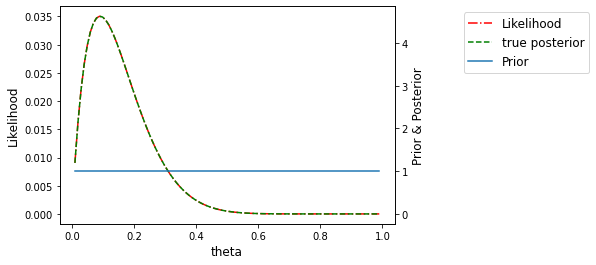

In [81]:
# closed form of beta posterior
a = prior_dist().concentration1
b = prior_dist().concentration0

exact_posterior = dist.Beta(concentration1=a + n_heads, concentration0=b + n_tails)

theta_range = jnp.linspace(0.01, 0.99, 100)

ax = plt.gca()
ax2 = ax.twinx()
posterior_prob = exact_posterior.prob(theta_range)
(plt2,) = ax2.plot(theta_range, posterior_prob, "g--", label="true posterior")
(plt3,) = ax2.plot(theta_range, prior_dist().prob(theta_range), label="Prior")

theta_map = theta_range[jnp.argmax(posterior_prob)]
y_max = posterior_prob.max()
# plt4 = ax2.vlines(theta_map,0,y_max ,label=f"$\\theta\_map={round(theta_map,2)}$", color="black", linestyle="-.")

likelihood = jax.vmap(lambda x: jnp.prod(likelihood_dist(x).prob(dataset)))(theta_range)
(plt1,) = ax.plot(theta_range, likelihood, "r-.", label="Likelihood")

ax.set_xlabel("theta")
ax.set_ylabel("Likelihood")
ax2.set_ylabel("Prior & Posterior")
ax2.legend(handles=[plt1, plt2, plt3], bbox_to_anchor=(1.6, 1));

## HMC using Blackjax
Reference: https://blackjax-devs.github.io/blackjax/examples/Introduction.html

In [5]:
def log_prior_likelihood_fn(theta):
    likelihood_log_prob = likelihood_dist(theta).log_prob(dataset).sum()  # log probability of likelihood
    prior_log_prob = prior_dist().log_prob(theta)  # log probability of prior
    return likelihood_log_prob + prior_log_prob  # log_prior_liklihood


logprob = lambda x: log_prior_likelihood_fn(**x)

In [33]:
inv_mass_matrix = jnp.array([5])
num_integration_steps = 60
step_size = 1e-3

hmc = blackjax.hmc(logprob, step_size, inv_mass_matrix, num_integration_steps)

In [34]:
initial_position = {"theta": 0.5}
initial_state = hmc.init(initial_position)
hmc_kernel = jax.jit(hmc.step)

In [35]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [36]:
n_chains = 4
n_samples = 1000
keys = jax.random.split(key, n_chains)
chain_states = jax.vmap(inference_loop, in_axes=(0, None, None, None))(keys, hmc_kernel, initial_state, n_samples)
chains = chain_states.position["theta"].block_until_ready()

### Density of samples and True posterior

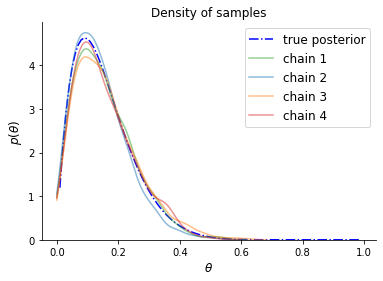

In [80]:
plt.figure()
plt.title("Density of samples")
plt.plot(theta_range, exact_posterior.prob(theta_range), "b-.", label="true posterior")

colors = ["tab:green", "tab:blue", "tab:orange", "tab:red"]
for no, chain in enumerate(chains):
    sns.kdeplot(chain, clip=(0.0, 1.0), label=f"chain {no+1}", alpha=0.5, color=colors[no])

plt.xlabel("$\\theta$")
plt.ylabel("$p(\\theta)$")
sns.despine()
plt.legend();

### Trace plot

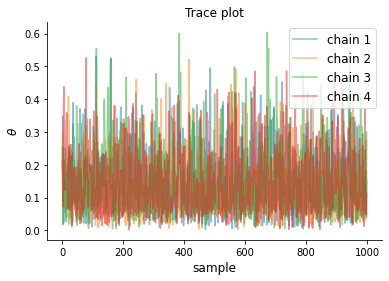

In [38]:
plt.figure()
plt.title("Trace plot")
for no, chain in enumerate(chains):
    plt.plot(chain, label=f"chain {no+1}", alpha=0.5)

plt.xlabel("sample")
plt.ylabel("$\\theta$")
sns.despine()
plt.legend();

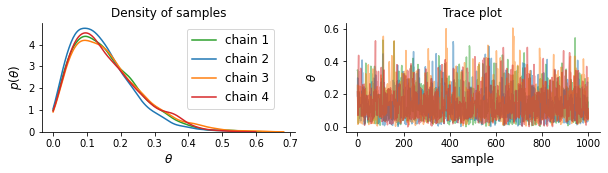

In [51]:
LATEXIFY = "LATEXIFY" in os.environ
FIG_SIZE = (10, 2) if not LATEXIFY else None
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIG_SIZE)

ax1.set_title("Density of samples")
colors = ["tab:green", "tab:blue", "tab:orange", "tab:red"]

for no, chain in enumerate(chains):
    sns.kdeplot(chain, ax=ax1, clip=(0.0, 1.0), label=f"chain {no+1}", color=colors[no])

ax1.set_xlabel("$\\theta$")
ax1.set_ylabel("$p(\\theta)$")
ax1.legend(bbox_to_anchor=(0.55, 1))
sns.despine()

ax2.set_title("Trace plot")
for no, chain in enumerate(chains):
    ax2.plot(chain, label=f"chain {no+1}", alpha=0.5, color=colors[no])

ax2.set_xlabel("iteration")
ax2.set_ylabel("$\\theta$")
sns.despine()
savefig("bb_hmc_trace")  # to save figure set FIG_DIR="path/to/figure" enviornment variable